# Going Deeper 06 Generative Adversarial Network 
###### 온라인 2기 코어 박수경

이번 과제에서는 두 개의 네트워크가 서로 경쟁하며 real에 가까운 이미지를 생성하는 GAN을 학습해본다. (모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야할 것들이 많다.)  

데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보기로 한다.  

> - POINT  
  >이미지 데이터의 shape는  (32, 32, 3)  
  >컬러이미지 (시각화 과정에서 고려해야 한다.)   
  >학습이 진행되는 양상과 모델 구조에 신경 쓰기  


In [1]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [2]:
import os
import glob
import time

import PIL
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 1. 작업환경과 데이터셋 준비

다음의 디렉토리를 구성한다.  
~/aiffel/dcgan_newimage/cifar10/generated_samples  
~/aiffel/dcgan_newimage/cifar10/training_checkpoints  
~/aiffel/dcgan_newimage/cifar10/training_history  

CIFAR-10 데이터셋 또한 tf.keras 에서 제공하는 datasets을 통해 불러올수 있다.

In [3]:
cifar10 = tf.keras.datasets.cifar10

In [4]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [5]:
train_x, test_x = load_data(label = 8)
train_x.shape

(5000, 32, 32, 3)

나는 이미지 중에서 레이블이 8, 즉 'ship'인 이미지만을 가지고 와 학습을 하고 결과를 내 보려고 한다. 해당하는 레이블의 데이터만 로드하는 함수를 정의하고 label이 5인 개 이미지를 train_x 와 test_x로 불러왔다.

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화  
- 로드한 학습 데이터 시각화.  
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 구성.   

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


데이터셋의 첫 10개를 이미지로 불러와본다. 

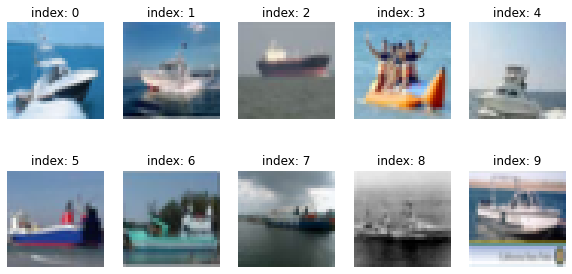

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')  #불필요한 축 지우기

plt.show()

In [8]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [9]:
BUFFER_SIZE = 5000  # 배치 사이즈보다는 크게 설정하기 (전체를 섞기 위해)
BATCH_SIZE = 512

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.

## STEP 2. 생성자 모델 구현하기
(32, 32, 3)의 shape를 가진 이미지를 생성하는 generator 모델을 만드는 함수를 정의한다.  
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여, 방금 구현한 생성자로 랜덤 이미지를 생성.  
생성된 랜덤 이미지 shape 확인.

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*768, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 768)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(384, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(192, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
batch_normalization (BatchNo (None, 49152)             196608    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 49152)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 768)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 384)         7372800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 384)         1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 384)         0

- **Conv2DTranspose?**  

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [15]:
chan_0 = generated_image[0,:,:,0]
chan_0
chan_1 = generated_image[0,:,:,1]
chan_2 = generated_image[0,:,:,2]
chan_2

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[ 6.3332634e-05,  6.5925420e-04,  5.4739084e-04, ...,
        -9.9463761e-04,  3.6859238e-03, -1.2879412e-03],
       [ 4.6342048e-03, -5.3894040e-03,  5.6135166e-03, ...,
        -8.1608035e-03,  5.1378729e-03, -8.4033618e-03],
       [-8.6566404e-04, -2.3771890e-03,  1.8351024e-03, ...,
         3.0809036e-03, -6.5796315e-03, -7.7982349e-03],
       ...,
       [ 2.7130672e-03, -4.1192756e-03,  2.9122159e-03, ...,
        -1.4221792e-02, -1.2536939e-03,  4.6363347e-03],
       [ 1.0549844e-03,  3.9232410e-03,  2.9376622e-03, ...,
        -1.6050680e-03,  8.3449641e-03, -1.2659244e-02],
       [ 3.0891132e-04, -1.7464823e-03, -9.0996170e-04, ...,
        -2.7402502e-04, -5.3798482e-03,  1.1537763e-02]], dtype=float32)>

In [16]:
generated_image[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-7.5802102e-04,  6.4805162e-04,  6.3332634e-05],
        [-2.7887628e-04,  2.8704517e-03,  6.5925420e-04],
        [-2.9127148e-03,  2.4147765e-03,  5.4739084e-04],
        ...,
        [ 1.0826974e-04, -3.2639252e-03, -9.9463761e-04],
        [-3.1510417e-03, -9.4159727e-04,  3.6859238e-03],
        [-1.7867645e-03,  3.5157162e-03, -1.2879412e-03]],

       [[ 1.3173221e-03, -2.8748792e-03,  4.6342048e-03],
        [-1.6095174e-03,  1.7949553e-03, -5.3894040e-03],
        [-9.1529032e-03, -8.9933565e-03,  5.6135166e-03],
        ...,
        [ 3.3301732e-03,  1.6488031e-03, -8.1608035e-03],
        [-4.4139181e-03, -2.2135657e-04,  5.1378729e-03],
        [ 1.6782901e-03,  2.3187946e-03, -8.4033618e-03]],

       [[-1.8318938e-03, -1.3086348e-03, -8.6566404e-04],
        [-7.6831534e-04,  4.2210794e-03, -2.3771890e-03],
        [ 2.0775595e-04,  3.9282404e-03,  1.8351024e-03],
        ...,
        [ 7.9646967e-03,  2.127216

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


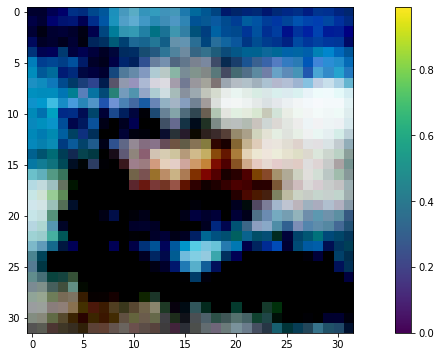

In [43]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기
(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성.  

In [19]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(384, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1)) # 리얼, 페이크

    return model

In [20]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 384)       29184     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 384)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 384)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         1228928   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## STEP 4. 손실함수와 최적화 함수 구현하기
생성자와 판별자의 손실함수(loss)를 작성해 보았다.  
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 만든다.
생성자와 판별자를 최적화하는 optimizer를 정의한다.

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 손실함수(loss function) : Cross Entropy   
이진 교차 엔트로피(binary cross entropy)를 사용한다.  

각각의 네트워크의 목표는 서로 상충한다.  
생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것  
판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것  

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

generator와 discriminator의 learning rate를 다르게 설정할 수 있다. 몇 번 시도한 결과 값이 같은 것보다는 네트워크가 학습하는 정도에 따라 조금씩 다르게 조절해 보니 더 괜찮은 성능을 보였다.  

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-3)

## STEP 5. 훈련과정 상세 기능 구현하기
1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 만든다.  
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 만든다.
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 만든다.  
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정한다.  
이러한 과정을 통해 훈련 과정을 저장해 둘 수 있으며 checkpoint를 불러와서 모델 학습을 재개할 수 있다.  

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [28]:
# train_step
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [30]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6   

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

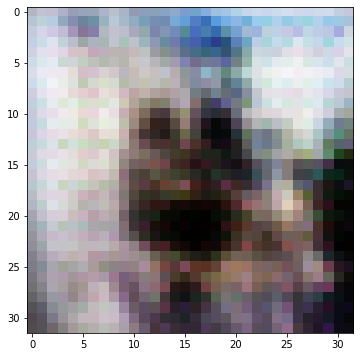

In [33]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  

### STEP 7. 학습 과정 진행하기

In [34]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

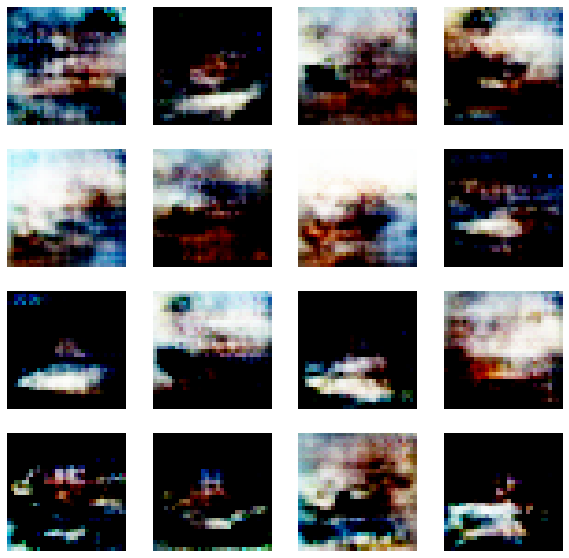

Time for training : 3929 sec


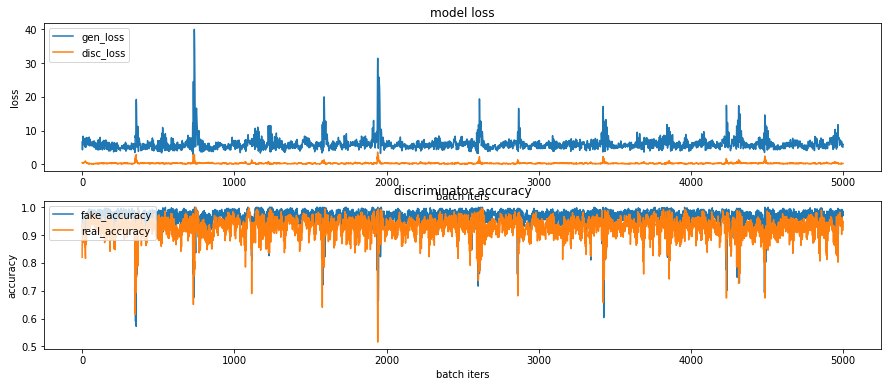

CPU times: user 1h 6min 51s, sys: 5min 15s, total: 1h 12min 6s
Wall time: 1h 5min 29s


In [36]:

%%time
train(train_dataset, EPOCHS, save_every)

# # 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성

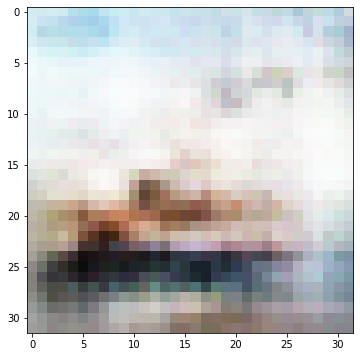

In [52]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인. 
noise_2 = tf.random.normal([1, 100])
generated_image_2 = generator(noise_2, training=False)

np_generated_2 = generated_image_2.numpy()
np_generated_2 = (np_generated_2 * 127.5) + 127.5   # reverse of normalization
np_generated_2 = np_generated_2.astype(int)
plt.imshow(np_generated_2[0])
plt.show()  

얼핏 보면 배 같아 보이기도 하다.

In [53]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_ship_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


![](cifar10_ship_dcgan.gif)  

학습과정을 이어붙인 이미지이다.  
학습이 썩 잘 이루어지지 않았다.  


In [55]:
anim_file_2 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_ship_history_dcgan.gif'

with imageio.get_writer(anim_file_2, mode='I') as writer:
    filenames_2 = glob.glob('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history*.png'.format(os.getenv('HOME')))
    filenames_2 = sorted(filenames_2)
    last = -1
    for i, filename in enumerate(filenames_2):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image2 = imageio.imread(filename)
        writer.append_data(image2)
    image2 = imageio.imread(filename)
    writer.append_data(image2)

![](cifar10_ship_history_dcgan.gif)  

학습 과정의 loss, accuracy 를 확인하면 학습을 하기는 하는데 generator 가 이미지를 만들어내는 능력이 조금 떨어지는 것을 확인할 수 있다. generator가 조금 더 이미지를 잘 생성할 수 있게 구조를 바꿔보려고 했지만 시간이 없었다.  
과제를 제출한 후 조금 더 개선해 볼 것이다! (깃허브에 업데이트 할 예정)

## Discussion  

GAN을 잘 학습하는 게 생각보다 어려웠다. 문제가 되는 점을 몇가지로 짚어본다면 다음과 같다.  

- 두 개의 적대적인 네트워크가 서로 잘 구성되고, 또 어느 한 쪽이 너무 우세하지 않도록 학습이 진행되어야 하는데 계속 한 쪽으로 치우쳤다. generator의 성능을 조금 더 개선해야 했다. 


- 그래프의 중간중간에 간혹 fake_accuracy가 낮아지는 지점이 있다. 이 부분에서 만들어낸 이미지는 제법 배 같을 것이다. 0.5/0.5로 수렴해야하는데 discriminator가 너무 잘 맞춘다.  


- loss 그래프를 확인한 결과 전체적인 loss가 학습이 진행됨에 따라 그리 개선되지 않는 모습을 보였다. (그래프 상에서 특별한 추세 없이 요동만 치고 있다.)  


- 이를 바탕으로 generator의 모델 구조, learning_rate 조절 등을 생각해 보았다. 이미지의 feature를 학습하는 conv2D레이어의 필터 윈도우 크기를 좀 줄이는 게 더 국소적인 feature을 뽑아낼 수 있지 않을까 하고도 생각했다.  


- 배 레이블만으로 진행한 학습이어서 데이터 양이 5천장으로 매우 적다. 이 부분도 영향을 줄 수 있다고 생각했다.  



여러가지 문제점이 수도 없이 많다.  
개선된 결과를 낼 수 없어서 매우 아쉬웠다.  
하지만 GAN 의 동작 원리나, 이미지를 생성하는 TASK가 매우 흥미로웠다. 꼭 더 공부하여 괜찮은 이미지를 만들어 낼 것이다.


## References

- How to Train a GAN? Tips and tricks to make GANs work(https://github.com/soumith/ganhacks)   
- 10 Lessons I Learned Training GANs for one Year(https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)    
- Tips for Training Stable Generative Adversarial Networks(https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)     
- Improved Techniques for Training GANs(paper)(https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)  